## Set up

import libs

In [111]:
import math
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.INFO)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

print tf.__version__

1.12.0


## Data
load and examine the data
the measurments are with on decimal digit precision
there are few outliers in the height measurment - normal_height removes those
on the plot it can be seen diensions increase roughly liearly up to certain point and then they almost stop changing

In [145]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data", 
    sep=",",
    index_col=False,
    names = ["sex", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight", "rings"]
)
normal_height  = df.height <= 0.4 
young = df.rings <= 11
old = df.rings > 11
df = df[normal_height & young]
df.rings = df.rings.astype(float)
df["volume"] = 1000*df["length"]*df["diameter"]*df["diameter"]
df["whole_weight_sq"] = np.sqrt(df["whole_weight"])
df["shell_weight_sq"] = np.sqrt(df["shell_weight"])
df["shucked_weight_sq"] = np.sqrt(df["shucked_weight"])
df["viscera_weight_sq"] = np.sqrt(df["viscera_weight"])
df["sex_color"] = df.apply(lambda row:ord(row["sex"]), axis=1)
sexes = df.sex.unique()
df.head(100)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,volume,whole_weight_sq,shell_weight_sq,shucked_weight_sq,viscera_weight_sq,sex_color
1,M,0.3,0.3,0.1,0.2,0.1,0.0,0.1,7.0,24.6,0.5,0.3,0.3,0.2,77
2,F,0.5,0.4,0.1,0.7,0.3,0.1,0.2,9.0,93.5,0.8,0.5,0.5,0.4,70
3,M,0.4,0.4,0.1,0.5,0.2,0.1,0.2,10.0,58.6,0.7,0.4,0.5,0.3,77
4,I,0.3,0.3,0.1,0.2,0.1,0.0,0.1,7.0,21.5,0.5,0.2,0.3,0.2,73
5,I,0.4,0.3,0.1,0.4,0.1,0.1,0.1,8.0,38.2,0.6,0.3,0.4,0.3,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,M,0.3,0.3,0.1,0.2,0.1,0.0,0.1,9.0,22.4,0.4,0.3,0.3,0.2,77
138,F,0.4,0.3,0.1,0.4,0.2,0.1,0.1,9.0,42.8,0.6,0.3,0.4,0.3,70
139,M,0.4,0.3,0.1,0.3,0.1,0.1,0.1,9.0,30.5,0.5,0.3,0.3,0.2,77
140,F,0.6,0.4,0.2,0.8,0.3,0.2,0.2,10.0,111.9,0.9,0.5,0.6,0.5,70


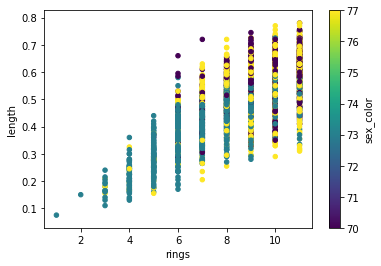

In [146]:
#df.describe()
df.plot(kind='scatter',x='rings',y='length',c='sex_color', colormap='viridis')
plt.show()

In [147]:
# Split into train and eval
np.random.seed(seed=1) #makes split reproducible
randoms = np.random.rand(len(df))
msk_train = randoms < 0.6
msk_eval = np.logical_and(randoms > 0.6, randoms < 0.8)
msk_test = randoms > 0.8
train_df = df[msk_train]
eval_df = df[msk_eval]
test_df = df[msk_test]

## Linear regression model

In [148]:
LINEAR_OUTDIR = './abalones_linear_trained'
def create_estimator(output_dir):
    return tf.estimator.LinearRegressor(
       model_dir = output_dir, 
       feature_columns = [
           tf.feature_column.numeric_column('length'),
           tf.feature_column.numeric_column('diameter'),
           tf.feature_column.numeric_column('height'),
       ])    
    
def train_and_evaluate(output_dir, num_train_steps):
  estimator = create_estimator(output_dir)
  #Add rmse evaluation metric
  def rmse(labels, predictions):
    pred_values = tf.cast(predictions['predictions'],tf.float64)
    return {'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)}
  estimator = tf.contrib.estimator.add_metrics(estimator,rmse)
  
  train_spec=tf.estimator.TrainSpec(
                       input_fn = tf.estimator.inputs.pandas_input_fn(x = train_df,
                                              y = train_df["rings"],  
                                              num_epochs = None,
                                              shuffle = True),
                       max_steps = num_train_steps)
  eval_spec=tf.estimator.EvalSpec(
                       input_fn = tf.estimator.inputs.pandas_input_fn(x = eval_df,
                                              y = eval_df["rings"],  
                                              num_epochs = 1,
                                              shuffle = False),
                       steps = None,
                       start_delay_secs = 1, # start evaluating after N seconds
                       throttle_secs = 10,  # evaluate every N seconds
                       )
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

def make_test_input_fn(df):
    return tf.estimator.inputs.pandas_input_fn(
        x = df,
        y = None,
        batch_size = 128,
        shuffle = False,
        queue_capacity = 1000
    )

def predict(df):
    model = create_estimator(LINEAR_OUTDIR)
    return model.predict(input_fn = make_test_input_fn(df))

### Train the model
training 10000 steps reaches loss slighly above 600

In [149]:
# remove trained model dir - start fresh each time
#shutil.rmtree(LINEAR_OUTDIR, ignore_errors = True)

In [150]:
#train_and_evaluate(LINEAR_OUTDIR, num_train_steps = 3000)

### Predict
use trained model to make some predictions

In [152]:
#predictions = list(predict(test_df))
#for i in range(0, test_df.shape[0]):
#    print "actual: ", test_df.iloc[i].rings, ", predicted:", predictions[i]['predictions'][0]

## Neural network

In [153]:
DNN_OUTDIR = './abalones_dnn_trained'
def dnn_create_estimator(output_dir):
    optimizer = tf.train.FtrlOptimizer(learning_rate = 0.1)
    return tf.estimator.DNNRegressor(
        hidden_units = [256, 32, 2],
        model_dir = output_dir, 
        feature_columns = [
            tf.feature_column.indicator_column(
                tf.feature_column.categorical_column_with_vocabulary_list("sex", sexes)
            ),
            tf.feature_column.numeric_column('length'),
            tf.feature_column.numeric_column('diameter'),
            tf.feature_column.numeric_column('height'),
            tf.feature_column.numeric_column('whole_weight_sq'),
            tf.feature_column.numeric_column('shucked_weight_sq'),
            tf.feature_column.numeric_column('viscera_weight_sq'),
            tf.feature_column.numeric_column('shell_weight_sq'),
        ],
        optimizer = optimizer
    )    
    
def dnn_train_and_evaluate(output_dir, num_train_steps):
  estimator = dnn_create_estimator(output_dir)
  #Add rmse evaluation metric
  def rmse(labels, predictions):
      pred_values = tf.cast(predictions['predictions'],tf.float64)
      return {'rmse': tf.metrics.root_mean_squared_error(labels, pred_values)}
  estimator = tf.contrib.estimator.add_metrics(estimator,rmse)
  
  train_spec=tf.estimator.TrainSpec(
                       input_fn = tf.estimator.inputs.pandas_input_fn(x = train_df,
                                              y = train_df["rings"],  
                                              num_epochs = None,
                                              shuffle = True),
                       max_steps = num_train_steps)
  eval_spec=tf.estimator.EvalSpec(
                       input_fn = tf.estimator.inputs.pandas_input_fn(x = eval_df,
                                              y = eval_df["rings"],  
                                              num_epochs = 1,
                                              shuffle = False),
                       steps = None,
                       start_delay_secs = 1, # start evaluating after N seconds
                       throttle_secs = 10,  # evaluate every N seconds
                       )
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

def dnn_make_test_input_fn(df):
    return tf.estimator.inputs.pandas_input_fn(
        x = df,
        y = None,
        batch_size = 128,
        shuffle = False,
        queue_capacity = 1000
    )

def dnn_predict(df):
    model = dnn_create_estimator(DNN_OUTDIR)
    return model.predict(input_fn = dnn_make_test_input_fn(df))

### Train the model
training 10000 steps reaches loss slighly above 600

In [154]:
# remove trained model dir - start fresh each time
shutil.rmtree(DNN_OUTDIR, ignore_errors = True)

In [155]:
dnn_train_and_evaluate(DNN_OUTDIR, num_train_steps = 5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1f14f2c210>, '_model_dir': './abalones_dnn_trained', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker',

### Predict

In [156]:
sample_test_df = test_df.sample(frac=1)
predictions = map(lambda p: p['predictions'][0], list(dnn_predict(sample_test_df)))
rmse = np.sqrt(np.mean((sample_test_df.rings - predictions)**2))
for i in range(0, sample_test_df.shape[0]):
    actual = sample_test_df.iloc[i].rings
    predicted = predictions[i]
    diff = np.abs(actual-predicted)
    print "actual: ", actual, ", predicted:", predicted, ", diff:", diff
print "RMSE:", rmse


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1eddde3250>, '_model_dir': './abalones_dnn_trained', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
ac

actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  6.0 , predicted: 8.213942 , diff: 2.2139415740966797
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  6.0 , predicted: 8.213942 , diff: 2.2139415740966797
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
act

actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  6.0 , predicted: 8.213942 , diff: 2.2139415740966797
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
act

actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  5.0 , predicted: 8.213942 , diff: 3.2139415740966797
actual:  9.0 , predicted: 8.213942 , diff: 0.7860584259033203
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  10.0 , predicted: 8.213942 , diff: 1.7860584259033203
actual:  6.0 , predicted: 8.213942 , diff: 2.2139415740966797
actual:  7.0 , predicted: 8.213942 , diff: 1.2139415740966797
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
actual:  8.0 , predicted: 8.213942 , diff: 0.2139415740966797
actual:  11.0 , predicted: 8.213942 , diff: 2.7860584259033203
a